# Dom model training
We will be looking over the extracted tags and see if we can correctly predict the label of the data using some ML model. At first, we will be trying it on the first type of datasets, as described in the main notes and test it on both the same dataset, and the dataset of the entire website.

But first, we will do some inspection of the records to see if we can make some inferences about the predictions or use them as diagnostics if the model fails.

We will also be aproaching the task as both a binary clasification problem for each label and and a multiclass one with all of them.

In [1]:
%matplotlib inline
# standard library
import itertools
import sys, os
import re
import glob

from urllib.parse import urlparse

# pandas
import pandas as pd
import dask.dataframe as dd

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# skelearn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier

# local imports
sys.path.append(os.path.join(os.getcwd(), "../src"))
from utils import get_domain_from_url

# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

We will be starting with the data from OLX and do some exploration first.

In [2]:
# load the data
df = pd.read_csv('../data/ecommerce-new/final/split-url/www.olx.ro.csv').drop('Unnamed: 0', axis='columns')
df.head()

,url,path,depth,sibling_pos,no_classes,has_id,no_children,has_text,descendant1_no_nodes,descendant1_no_children_avg,...,descendant1_tags_u,descendant1_tags_ul,descendant1_tags_video,detail_description_label,detail_image_label,detail_price_label,detail_title_label,list_image_label,list_price_label,list_title_label
0,https://www.olx.ro/auto-masini-moto-ambarcatiu...,/html/head,2,0,0,0,64,0,64,0.0,...,0,0,0,0,0,0,0,0,0,0
1,https://www.olx.ro/auto-masini-moto-ambarcatiu...,/html/head/comment()[4],3,51,0,0,0,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,https://www.olx.ro/auto-masini-moto-ambarcatiu...,/html/body/div[1]/section/div/div/div[3]/div[1...,12,0,0,0,0,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,https://www.olx.ro/auto-masini-moto-ambarcatiu...,/html/body/div[1]/section/div/div/div[3]/div[1...,12,0,0,0,0,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,https://www.olx.ro/auto-masini-moto-ambarcatiu...,/html/body/div[1]/section/div/div/div[3]/div[2...,10,4,0,0,1,0,1,1.0,...,0,0,0,0,0,0,0,0,0,0


Let's take a look at how the features for some of the labeled data look to see if we can spot any patterns.

As we can see, there is almost no diffrence between the records with this label. To check this exhaustively, we will check the average absolute z-score for all the columns for a given label.

In [3]:
label_cols = ['detail_description_label', 'detail_image_label', 'detail_price_label', 
              'detail_title_label', 'list_image_label', 'list_price_label', 'list_title_label']
one_hot_cols = list(filter(lambda x: 'tag' in x, df.columns))
df['label'] = df[label_cols].idxmax(1)  # revse one-hot
labeled_df = df.copy().loc[df[label_cols].any(1), :]

# use the categorical column for groupby
grouped_df = labeled_df.drop(['url', 'path'] + one_hot_cols + label_cols, axis='columns').groupby('label', as_index=True)
z_score_df = grouped_df.agg(lambda x: ((x - x.mean()) / x.std()).abs().mean()).fillna(0)
z_score_df

,depth,sibling_pos,no_classes,has_id,no_children,has_text,descendant1_no_nodes,descendant1_no_children_avg,descendant1_has_id_avg,descendant1_no_classes_avg,...,ancestor4_no_classes,ancestor4_has_id,ancestor4_no_children,ancestor4_has_text,ancestor5_depth,ancestor5_sibling_pos,ancestor5_no_classes,ancestor5_has_id,ancestor5_no_children,ancestor5_has_text
label,,,,,,,,,,,,,,,,,,,,,
detail_description_label,0.000000,0.0,0.0,0.0,0.81778,0.000000,0.81778,0.61083,0.0,0.61083,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
detail_image_label,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
detail_price_label,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
list_image_label,0.124755,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.124755,0.124755,0.521047,0.0,0.0,0.0
list_price_label,0.122916,0.0,0.0,0.0,0.00000,0.122916,0.00000,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.122916,0.000000,0.000000,0.0,0.0,0.0
list_title_label,0.122916,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.122916,0.000000,0.000000,0.0,0.0,0.0


As we can see, the z scorse have varied values, but are very sparsely distributed. To actually get a better metric of the variance of the alues, we will average over the z-score of every column in each group.

In [4]:
z_score_df.mean(axis=1)

label
detail_description_label    0.099795
detail_image_label          0.000000
detail_price_label          0.012901
list_image_label            0.036785
list_price_label            0.044005
list_title_label            0.018121
dtype: float64

From the table above, we can observe that most feature values for each of the label groups, reside at less than 10% of standard deviation away from their mean. This means that the sought values are grouped in afairly tight cluster, making them not very varied.

To observe this visually, we will plot boxplots for the zscore inside of its own class of each variable. This way we can see how far the values stray from their mean.

In [5]:
# z-normalize al lthe columsn but label and create a dataset we can plot later
z_score_cols = df.drop(['url', 'path', 'label'] + one_hot_cols + label_cols, axis='columns').columns  # clumns to use for labeled df

# we can only use the labeled cols as grouping by with NaNs fail
labeled_df.loc[:, z_score_cols] = labeled_df.groupby('label').transform(lambda x: (x - x.mean()) / x.std()).fillna(0)
labeled_z_score_df = labeled_df.drop(['url', 'path'] + one_hot_cols + label_cols, axis='columns')

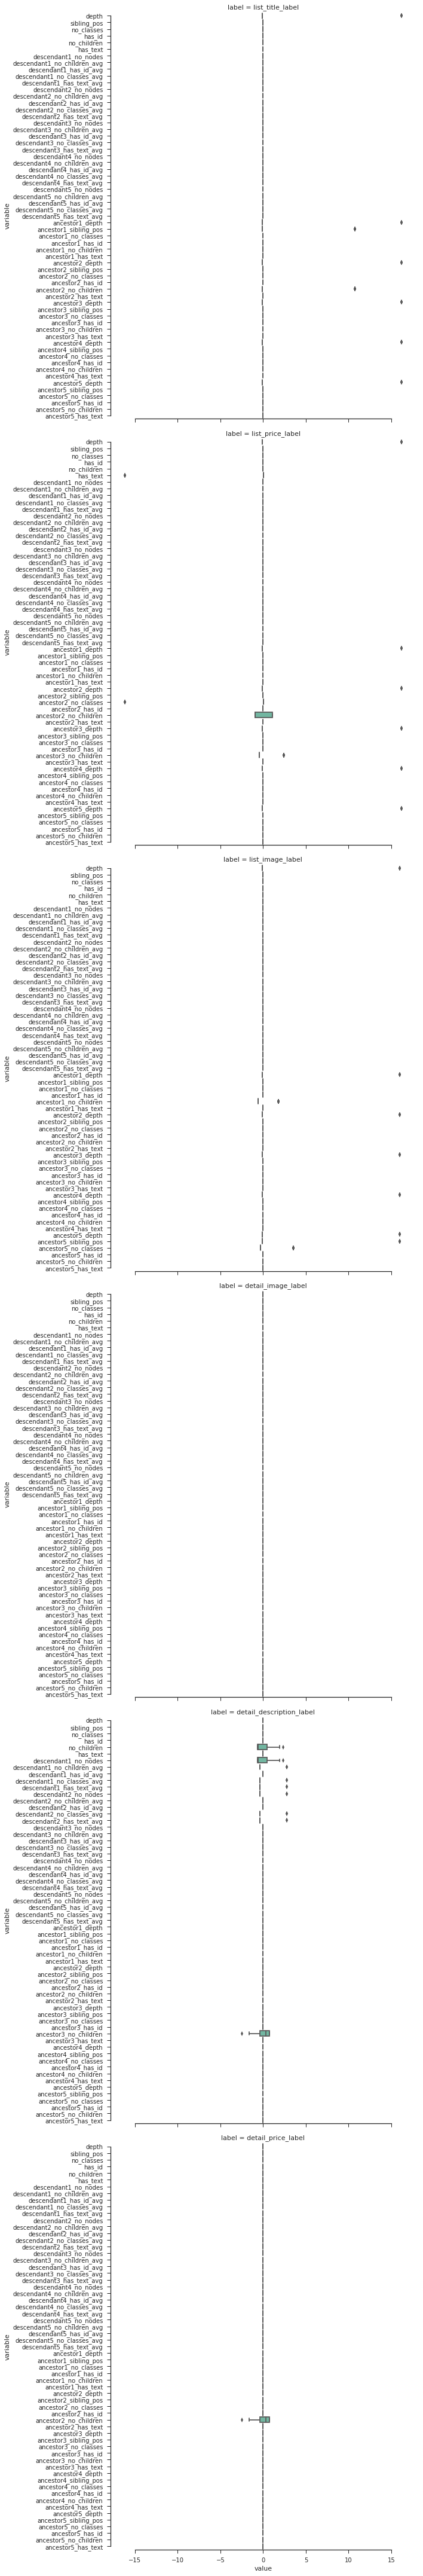

In [6]:
# melt into long format so we can plot with seaborn
g = sns.FacetGrid(data=pd.melt(labeled_z_score_df, id_vars=['label']), row='label', size=10)
g.map(sns.boxplot, 'value', 'variable', orient='h', )
sns.despine(trim=True)

Having plotted the boxplots for each vriable for the z-scores of every class of labels we can see thatmost of them have z scores of 0, meaning there is literally no variation between the values. Some of the variables have the IQR of their z scores in around the (-1, 1) interval which is normal. Overall, this means that elements of the same class on a site might represent a single point in the high-dimensional feature space.
**Note** This means testing would revolve around the model just learning to differentiate one sample from the others. could it be considered overfitting if the training data has all the possible samples in the domain?

There are however a few very high outliers for variables wher the IQR is the point 0. These might be due to some differences in some particular page templates, or bad labeling, but comparing with the other variables which have zero variance, it might be normal entropy.


The problem that remains to be explored is how this data variaes accross different websites. In order to do this  we will be plotting the z scores  of all the labeled data and group them by their domains.

In [7]:
# get all the laabeled data from all the sites
ddf = dd.read_csv('../data/ecommerce-new/final/split-url/*.csv')
ddf = ddf.loc[ddf[label_cols].any(1), :].drop('Unnamed: 0', axis=1) # we drop unlabeled record not to clutter the memory
all_site_df = ddf.compute()  # transform to pandas
all_site_df['label'] = all_site_df[label_cols].idxmax(1)  # revse one-hot
all_site_df['domain'] = all_site_df['url'].apply(get_domain_from_url)  # add the domain

z_score_cols = all_site_df.drop(['url', 'path', 'label', 'domain'] + one_hot_cols + label_cols, axis='columns').columns  # columns to use for z-scores
all_site_df.loc[:, z_score_cols] = all_site_df.groupby('label').transform(lambda x: (x - x.mean()) / x.std()).fillna(0) # get z scores among all sites

In [8]:
# plot the boxplot
all_site_df = all_site_df.drop(['url', 'path'] + one_hot_cols + label_cols, axis='columns') # drop unplottable cols

# melt into long format so we can plot with seaborn
g = sns.FacetGrid(data=pd.melt(all_site_df, id_vars=['label', 'domain']), row='label', size=50, aspect=1)
g.map(sns.boxplot, 'value', 'variable', 'domain', orient='h')  # group hue by domain
g.set(xlim=(-10, 10))  # set the xlims
sns.despine(trim=True)

# add horizontal grid
for axes in g.axes.ravel():
    axes.xaxis.grid(True, linestyle='-')
    axes.yaxis.grid(True, linestyle='--')

Looking over the plot of the zscores grouped on a per site basis we can see some pearticular patterns emerging. The most obvious one is lack of variation for most descendant features especialy for descendents of  2 levels or more lower. This is  of course, due to the fact that all data we have labeled on the site is eiher a leaf node in the dom or the parent of a leaf node. Therefore, the descendant features are so iinvaried due tu the lack of such nodes. Although this might seem as redundance at first glance,those features actually convey information about the height of each node in the tree and fi our classes are mainly leafs in he DOM, it is crucical information.

As for the other features. we can see for each site patterns we noticed in the previous plot where we explored only data from one site, more specifically that each class of tags on a particular websites fits more-or-less a single point in the feature-space. Moreover, when they do happen to have diverge, they seem to diverg at most one standard deviation away from the mean(z-scores beloging o the (-1, 1) interval). They, however do show some potential for generalization, as several features whose IQR are of non-null length do show overlap between different websites.

Overall, the lack of variance among websites indicates that we don't need more data from a single website as it would be redundant information, but rather to train a model to find potential patterns we would need a small number of pages from many different websites.

### Dataset quality 
To asess the quality of the variables, we should first see if there is any corellation between them.

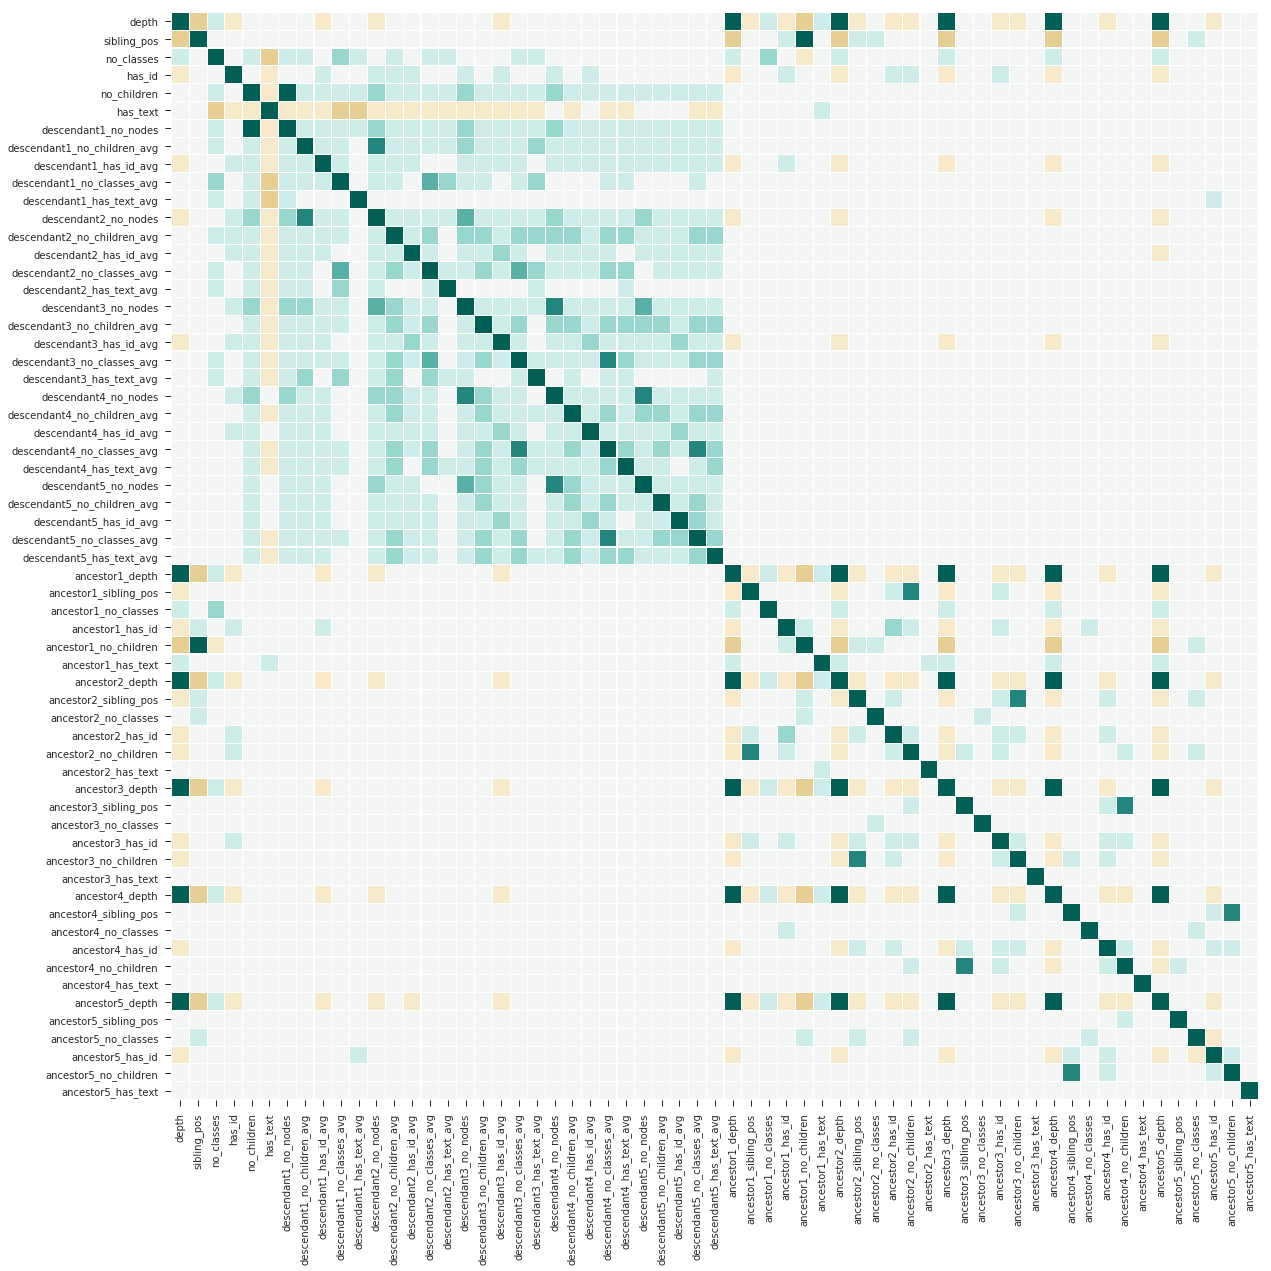

In [9]:
corr = dd.read_csv('../data/ecommerce-new/final/split-url/*.csv').drop(['url', 'path', 'Unnamed: 0'] + one_hot_cols + label_cols, axis='columns').compute().corr()

plt.figure(figsize=(20, 20))
cmap = sns.color_palette("BrBG", 11)
sns.heatmap(corr, square=True, center=0, vmin=-1, vmax=1, cmap=cmap, linewidths=0.1, cbar=False)

Looking at the corellation plot we can see some some correlations between ancestor and descendant featres on different levels of depth. These are all redundancies that can be removed and the dimensionality of the dataset reduced to increase performance. However, if we'l be using a neural net or some other model that does dimensionality reduction of its own, there should be no harm in keeping them.

In [10]:
# for better visualization, we will see which have the highest correlation
melt_corr = corr.unstack().reset_index().fillna(0)
melt_corr['pair'] = melt_corr.apply(lambda x: set([x['level_0'], x['level_1']]), axis=1).astype(str)
melt_corr = melt_corr[(melt_corr[0].abs() > 0.5) & (melt_corr['level_0'] != melt_corr['level_1'])]
melt_corr.drop_duplicates(subset='pair').drop('pair', axis=1).sort_values(by=0, ascending=False)

,level_0,level_1,0
31,depth,ancestor1_depth,1.000000
250,no_children,descendant1_no_nodes,1.000000
1928,ancestor1_depth,ancestor2_depth,0.999987
37,depth,ancestor2_depth,0.999987
2300,ancestor2_depth,ancestor3_depth,0.999960
43,depth,ancestor3_depth,0.999920
1934,ancestor1_depth,ancestor3_depth,0.999920
2623,ancestor3_depth,depth,0.999920
2672,ancestor3_depth,ancestor4_depth,0.999031
2306,ancestor2_depth,ancestor4_depth,0.998928


Most of the corellations her are no surpise, as the same feature for one level of descendants/acestors should be corelated to the same feature on directly adjacent levels, while those who are correlated, but more weakly, are still logic(ie. position among siblings and how many siblings there are)

## Classification
Here we will be trying to train a model to clasify in a one-vs-all manner for each of the classes. We will be trying to do it on the subsets of data described in the main document. We'll start with as ingle class and website, to test the soundness of the approach and then we'l do it for al websites and classes so we are able to generate some average performance metric.

As far as metrics go, given the skewness of the data, we will not be chasing accuracy, but rather precision, recall and F-score. Given the fact that ML algorithms tend to minimize cross-entropy which might only give good accuracy, we might need to compensate by either tuning the loss function of the model(for neural nets usng a weighted cross entropy) or oversample the small classes.

Also, if we're not oversampling, we'll have to use a stratified trai/test split too keep the proportions.

### One label. One Site
We'll begin by taking all tha pags that have one class(say *list-image*) from olx, split into train and test and evaulate the performance of a copuple of models.

In [11]:
df = pd.read_csv('../data/ecommerce-new/final/split-label/www.olx.ro-list_image_label-*.csv').drop('Unnamed: 0', axis=1)
df['label'] = df[label_cols].idxmax(1)  # revse one-hot
df.loc[~df[label_cols].any(1), 'label'] = 'noise'  # the irrelevant ones
df = df.drop(label_cols, axis=1)  # drop the one hot encodings
df.head()

,url,path,depth,sibling_pos,no_classes,has_id,no_children,has_text,descendant1_no_nodes,descendant1_no_children_avg,...,descendant1_tags_th,descendant1_tags_thead,descendant1_tags_time,descendant1_tags_title,descendant1_tags_tr,descendant1_tags_tspan,descendant1_tags_u,descendant1_tags_ul,descendant1_tags_video,label
0,https://www.olx.ro/auto-masini-moto-ambarcatiu...,/html/head/meta[12],3,44,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,noise
1,https://www.olx.ro/auto-masini-moto-ambarcatiu...,/html/head/meta[12],3,44,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,noise
2,https://www.olx.ro/auto-masini-moto-ambarcatiu...,/html/head/meta[12],3,44,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,noise
3,https://www.olx.ro/auto-masini-moto-ambarcatiu...,/html/head/meta[12],3,44,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,noise
4,https://www.olx.ro/auto-masini-moto-ambarcatiu...,/html/head/meta[12],3,44,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,noise


In [12]:
X = df.drop(['url', 'path', 'label'], axis='columns')  # the data

# convert to binary classes
Y = (df['label'] == 'list_image_label').astype(float)  
Y = Y.astype(float)

# split into train and test and keep class proportions
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [13]:
# classify
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)

# performance
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred, target_names=['noise', 'label']))

             precision    recall  f1-score   support

      noise       1.00      1.00      1.00     14658
      label       1.00      1.00      1.00       205

avg / total       1.00      1.00      1.00     14863



Perfect results as it is to be expeced when working with a single class on a single website. This confirms the hypothesis that the dom features in conjunction with an ML model perform just as well as XPaths when it comes to extracting data from type of page. How much this is because of the addition of *neighbourhood* features remains to be seen in a future experiment. For the moment being, we can confirm that, at least for this particular case, a nieghbourhood of 5 height and depth contains just as much information as an XPath dsecriptor.


### Train/Test -  Website Subset
The next step is to generalize the training and testing steps and apply them to all the possible combinations of train/test datasets. We'll be training on the subsets of samples from pages containing one class on one site and testing it, both on the same dataset and the subset of  samples from that entire site. We can use the entire site for testing as there is minimal overlap.

In [16]:
def train_and_evaluate(X_train, Y_train, X_test=None, Y_test=None, model_func=None, test_size=0.2):
    """Receives a a train dataset and optionally a test one. Does the splitting
    of the data in stratified manner so that the class proportions are preserved.
    If no test dataset is received, splits the training one in 2."""
    if X_test is None:
        X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=test_size, stratify=Y_train)

    scores = model_func(X_train, Y_train, X_test, Y_test)
    return pd.DataFrame(data=np.array(scores), index=['precision', 'recall', 'f1-score', 'support']).T

def X_Y_convert(df, label):
    # input the training data
    df = df.drop('Unnamed: 0', axis=1, errors='ignore')
    df['label'] = df[label_cols].idxmax(1)  # revse one-hot
    df.loc[~df[label_cols].any(1), 'label'] = 'noise'  # the irrelevant ones
    df = df.drop(label_cols, axis=1)  # drop the one hot encodings
    
    X = df.drop(['url', 'path', 'label'], axis='columns')  # the data

    # convert to binary classes
    Y = (df['label'] == label).astype(float)  
    Y = Y.astype(float)
    
    return X, Y

def train_and_eval_file(train_file, test_file=None, label=None, model_func=None):
    """Given a train file, test file, label to classify, and a function
    for the model returning the precision recall and fscore, return a dataframe
    of the observations."""
    X_test, Y_test = None, None  # init them this way
    df = pd.read_csv(train_file)
    X_train, Y_train = X_Y_convert(df, label)
    
    if test_file is not None:
        # input this too
        df = pd.read_csv(test_file)
        X_test, Y_test = X_Y_convert(df, label)
        
    # evaluate it and return
    print('{} - {} - {}'.format(train_file, test_file, label))  # for debug
    scores = train_and_evaluate(X_train, Y_train, X_test, Y_test, model_func)
    
    # convert it to a dataframe for easier handling
#    score_df = pd.DataFrame(data=np.array(scores), index=['precision', 'recall', 'f1-score', 'support']).T
#     score_df['label'] = ['noise', 'label']  # set the label

    return scores

   
def decision_tree_eval(X_train, Y_train, X_test, Y_test):
    # classify
    clf = DecisionTreeClassifier()
    clf.fit(X_train, Y_train)

    # performance
    Y_test_pred = clf.predict(X_test)
    # for debug
    print(classification_report(Y_test, Y_test_pred, target_names=['noise', 'label']))
    return precision_recall_fscore_support(Y_test, Y_test_pred)

In [17]:
train_and_eval_file('../data/ecommerce-new/final/split-label/www.olx.ro-list_price_label-*.csv', 
                    '../data/ecommerce-new/final/split-url/www.olx.ro.csv',
                    label='list_price_label', model_func=decision_tree_eval)

../data/ecommerce-new/final/split-label/www.olx.ro-list_price_label-*.csv - ../data/ecommerce-new/final/split-url/www.olx.ro.csv - list_price_label
             precision    recall  f1-score   support

      noise       1.00      1.00      1.00    132429
      label       1.00      1.00      1.00      1054

avg / total       1.00      1.00      1.00    133483



,precision,recall,f1-score,support
0,1.0,1.0,1.0,132429.0
1,1.0,1.0,1.0,1054.0


Now that we have a repetable method to test, we'll begin by testing it on the first class of datasets(the ones that contain only the pages of one site that contain a class of tags).

In [ ]:
def get_dataset_descr_from_filename(filename):
    """Given a filename return the dataset description of it.
    (website, label) meaning what website it's from and 
    what labels it contains(if it contains all data from
    one website, return "all")."""
    filename = filename.split('/')[-1]  # get the fiename proper
    filename_ptrn = r'(?P<website>[\w.-]+)(-(?P<label>.*)-\*)?\.csv'
    match = re.match(filename_ptrn, filename)  # get the match obj
    return (match.group('website'), match.group('label') or 'all')  # either website only or label and website

# example
get_dataset_descr_from_filename('../data/ecommerce-new/final/split-label/www.piata-az.ro-detail_description_label-*.csv')

In [ ]:
# get all the 1st class datasets
dataset_files = glob.glob('../data/ecommerce-new/final/split-label/*.csv')
test_result_dfs = []  # a list of all the test results, wiil concatenate at the end

for dataset_file in dataset_files:
    # some websites do not have a label so we have to check first
    if len(pd.read_csv(dataset_file)) != 0:
        # get the description to determine which label to do the classification on
        descr = get_dataset_descr_from_filename(dataset_file)
        results = train_and_eval_file(dataset_file, label=descr[1], model_func=decision_tree_eval)

        # label them with the experiment metadata
        results['train_website'] = results['test_website'] = descr[0]
        results['train_label'] = results['test_label'] = descr[1]
        results['classification_label'] = descr[1]

        # add it to the results
        test_result_dfs.append(results)

In [ ]:
dec_first_results = pd.concat(test_result_dfs, axis=0)
dec_first_results.mean()

In [ ]:
# see where it failed
dec_first_results[(dec_first_results < 1).any(axis=1)]

Apparently the model behaves extremely well when classifying on the same webpages it was trained on. This is beacause for such a small subset, with little variation(as we proved earlier with the boxplots) we can safely assume it's probably seen all the data of the positive class in the training step.

### Train - Website Subset. Test - Entire Website

Now we want to see if, after haing it trained on just the pages containing the data it can learn to differentiate those tags from all the other  tags n the website. This means training it on the subset that contain a class of tags and then on the entire website.

In [ ]:
train_dataset_files = glob.glob('../data/ecommerce-new/final/split-label/*.csv')
test_dataset_files = glob.glob('../data/ecommerce-new/final/split-url/*.csv')

train_datasets = [(file, ) + get_dataset_descr_from_filename(file) for file in train_dataset_files]
test_datasets = [(file, ) + get_dataset_descr_from_filename(file) for file in test_dataset_files]

# we need to air the label/website files with their website equivalent
train_file_df = pd.DataFrame(data=train_datasets, columns=('file', 'website', 'label'))
test_file_df = pd.DataFrame(data=test_datasets, columns=('file', 'website', 'label'))

# join them on the same website, with the proper suffixes
experiments_df = train_file_df.merge(test_file_df, on='website',  suffixes=('_train', '_test'))
experiments_df.head()  # inspect the experiments

In [ ]:
# now that we have the set of fiel pair to run the experiments on we can do just that
test_result_dfs = []  # a list of all the test results, will concatenate at the end

# ignore the index, not needed
for experiment in map(lambda x: x[1], experiments_df.iterrows()):
    # some websites do not have a label so we have to check first
    # also, check again for null files
    if len(pd.read_csv(experiment['file_train'])) != 0 and len(pd.read_csv(experiment['file_test'])) != 0:

        # we don't need to get the dsecription anymore, already extracted
        results = train_and_eval_file(experiment['file_train'], 
                                      experiment['file_test'], 
                                      label=experiment['label_train'], model_func=decision_tree_eval)

        # label them with the experiment metadata
        results['train_website'] = results['test_website'] = experiment['website']
        results['train_label'] = experiment['label_train']
        results['test_label'] = experiment['label_test']
        results['classification_label'] = experiment['label_train']

        # add it to the results
        test_result_dfs.append(results)

In [ ]:
dec_second_results = pd.concat(test_result_dfs, axis=0)
dec_second_results.loc[1, :].mean()

In [ ]:
# only use positive classes, andsee performence per site
dec_second_results.loc[1].groupby('train_website').mean()

As we can see, the results are not that great and vary significantly between websites. Thisould be correlated to the variations seen i nthe boxplots. Website with lower performance may be the same that had greater variance for features, whereas the other had more easily identifiable classes.

**TODO** see if there is any correlation

In [ ]:
def mlp_eval(X_train, Y_train, X_test, Y_test):
    # classify
    clf = MLPClassifier(hidden_layer_sizes=(100, 75, 50))
    clf.fit(X_train, Y_train)

    # performance
    Y_test_pred = clf.predict(X_test)
    # for debug
    print(classification_report(Y_test, Y_test_pred, target_names=['noise', 'label']))
    return precision_recall_fscore_support(Y_test, Y_test_pred)

In [ ]:
# now that we have the set of fiel pair to run the experiments on we can do just that
test_result_dfs = []  # a list of all the test results, will concatenate at the end

# ignore the index, not needed
for experiment in map(lambda x: x[1], experiments_df.iterrows()):
    # some websites do not have a label so we have to check first
    # also, check again for null files
    if len(pd.read_csv(experiment['file_train'])) != 0 and len(pd.read_csv(experiment['file_test'])) != 0:

        # we don't need to get the dsecription anymore, already extracted
        results = train_and_eval_file(experiment['file_train'], 
                                      experiment['file_test'], 
                                      label=experiment['label_train'], model_func=mlp_eval)

        # label them with the experiment metadata
        results['train_website'] = results['test_website'] = experiment['website']
        results['train_label'] = experiment['label_train']
        results['test_label'] = experiment['label_test']
        results['classification_label'] = experiment['label_train']

        # add it to the results
        test_result_dfs.append(results)

In [ ]:
mlp_second_results = pd.concat(test_result_dfs, axis=0)
mlp_second_results.loc[1, :].mean()

In [ ]:
mlp_second_results.loc[1].groupby('train_website').mean()

After using a MLP(3 hidden layer of 100, 75 and 50 neurons), the performance has jumped from an average precision of 55% to 82%. There is a slight 4% decrease in recall, but overall the F1 score imporved drastically. Okazii is, for example, a wenbsite where the f1-score nearly doubled. 

One of the reasons why there is such a drastic increase in performance might be because of all the redundant features that might negatively impact the performance of decision tree. 

Overall, the performance is significant and I reckon it could be inproved even further by employing methods t deal with skewed classes. Two methods that could be used, are the use of a weighted crosentropy loss function(maybe implemented in TF) or oversampling of the smaller class.

**TODO** Try to improve the model even further.

### Train/Test - Entire Website
In this last experiment we will train the model on all the pages of the website. Unlike the last experiment where the model was exposed to only the data on the pages that contained the classes, in this one the structure of tags on other pages will be known as well. This is not a problem, as we stated before, the entirety of the positive class is probably covered by those pages it appear on, the new data will only be relevant to the 0-class, potentially improving the precision of predictions.

In [ ]:
labels = ['detail_description_label', 'detail_image_label', 'detail_price_label', 
          'detail_title_label', 'list_image_label', 'list_price_label', 'list_title_label']
# get all the 1st class datasets
dataset_files = glob.glob('../data/ecommerce-new/final/split-url/*.csv')
test_result_dfs = []  # a list of all the test results, wiil concatenate at the end


for dataset_file in dataset_files:
    # some websites do not have a label so we have to check first
    if len(pd.read_csv(dataset_file)) != 0:
        for label in labels:
            # get the description to determine which label to do the classification on
            descr = get_dataset_descr_from_filename(dataset_file)
            results = train_and_eval_file(dataset_file, label=label, model_func=decision_tree_eval)

            # label them with the experiment metadata
            results['train_website'] = results['test_website'] = descr[0]
            results['train_label'] = results['test_label'] = descr[1]
            results['classification_label'] = label

            # add it to the results
            test_result_dfs.append(results)

In [ ]:
# compute the mean
dec_third_results = pd.concat(test_result_dfs, axis=0)
dec_third_results.loc[1, :].mean()

In [ ]:
dec_third_results.loc[1].groupby('train_website').mean()

In [ ]:
# same but with mlp
labels = ['detail_description_label', 'detail_image_label', 'detail_price_label', 
          'detail_title_label', 'list_image_label', 'list_price_label', 'list_title_label']
# get all the 1st class datasets
dataset_files = glob.glob('../data/ecommerce-new/final/split-url/*.csv')
test_result_dfs = []  # a list of all the test results, wiil concatenate at the end


for dataset_file in dataset_files:
    # some websites do not have a label so we have to check first
    if len(pd.read_csv(dataset_file)) != 0:
        for label in labels:
            # get the description to determine which label to do the classification on
            descr = get_dataset_descr_from_filename(dataset_file)
            results = train_and_eval_file(dataset_file, label=label, model_func=mlp_eval)

            # label them with the experiment metadata
            results['train_website'] = results['test_website'] = descr[0]
            results['train_label'] = results['test_label'] = descr[1]
            results['classification_label'] = label

            # add it to the results
            test_result_dfs.append(results)

In [ ]:
mlp_third_results = pd.concat(test_result_dfs, axis=0)
mlp_third_results.loc[1, :].mean()

As we can see, the MLP actual has lower precision when training on the whole website, this is, again, due to the the fact that it aims to maximize accuracy not precision. This is proof that, for better generalization we need a neural net with skewedness compensation.

## Conclusion
The code above, is more or less a proof of concept. We will be returning to running these experiments in a future notebook, where we will be doing so in a more cohesive and reproductible manner. Future work will include visualization of the results and potential analysis.